In [1]:
from utils.instrument_recognition import feature_preparator
from models.instrument_recognition.LSTMModel import LSTMModel
from models.instrument_recognition.TransformerModel import TransformerModel
import numpy as np
import torch
from utils.instrument_recognition import executor
from utils.instrument_recognition import plot_metrics
from utils.instrument_recognition import evaluate
from torch import nn
from utils.instrument_recognition import plot_confusion_matrix
from sklearn.metrics import classification_report
from utils.instrument_recognition import calculate_accuracy
from utils.instrument_recognition import squeeze_answer_matrix, get_exact_match_ratio, get_accuracy
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from utils.instrument_recognition.evaluate_multilabel import evaluate_multilabel

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
BATCH_SIZE = 8
DEVICE = torch.device('cuda')

In [4]:
dataloaders, idx_to_instrument, instrument_to_idx, shapes = feature_preparator(BATCH_SIZE)

In [5]:
train, val, test = dataloaders['accordion']

In [6]:
z = next(iter(train))
x = next(iter(val))
c = next(iter(test))

print(z[0].shape, z[1].shape, z[2].shape)
print(x[0].shape, x[1].shape, x[2].shape)
print(c[0].shape, c[1].shape, c[2].shape)
print(shapes)

torch.Size([8, 10, 128]) torch.Size([8]) torch.Size([8])
torch.Size([8, 10, 128]) torch.Size([8]) torch.Size([8])
torch.Size([8, 10, 128]) torch.Size([8]) torch.Size([8])
(14915, 2034, 3051)


 21%|██        | 21/100 [00:15<00:57,  1.37it/s]

Early stop!


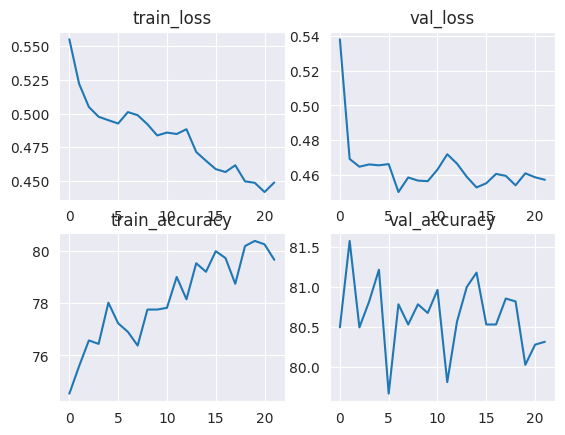

In [40]:
lstm_model = LSTMModel(128).to(DEVICE)
train_progress, val_progress = executor(
    DEVICE,
    lstm_model,
    train_dataloader = train,
    val_dataloader=val,
    epochs=100,
    learning_rate=0.0001,
    weight_decay=0.01,
    evaluate_per_iteration=15,
    early_stop_after=(15,  0.001)
)

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

       False       0.81      0.92      0.86       226
        True       0.54      0.31      0.40        70

    accuracy                           0.77       296
   macro avg       0.67      0.62      0.63       296
weighted avg       0.75      0.77      0.75       296



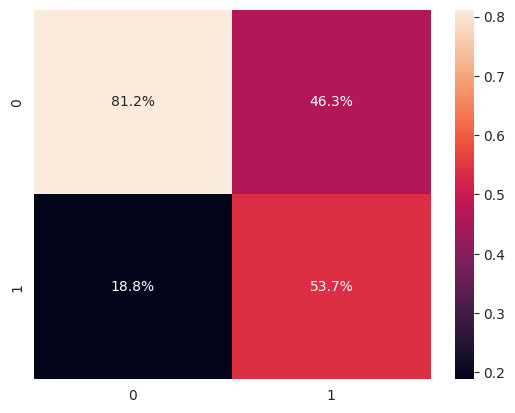

In [41]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, lstm_model, test, criterion=nn.BCEWithLogitsLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred)

 31%|███       | 31/100 [00:51<01:55,  1.68s/it]

Early stop!


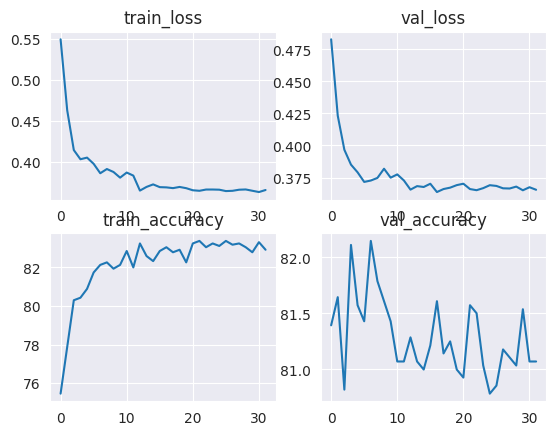

In [9]:
transformer_model = TransformerModel(input_dim=128,
                              num_layers=4,
                              output_dim=1,
                              num_heads=8,
                              dropout=0.1,
                              hidden_dim=128
                              ).to(DEVICE)

train_progress, val_progress = executor(
    DEVICE,
    transformer_model,
    train_dataloader = train,
    val_dataloader=val,
    epochs=100,
    learning_rate=0.0001,
    weight_decay=0.01,
    evaluate_per_iteration=15,
    early_stop_after=(15,  0.001)
)

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

       False       0.85      0.95      0.90       226
        True       0.74      0.46      0.57        70

    accuracy                           0.83       296
   macro avg       0.80      0.70      0.73       296
weighted avg       0.82      0.83      0.82       296



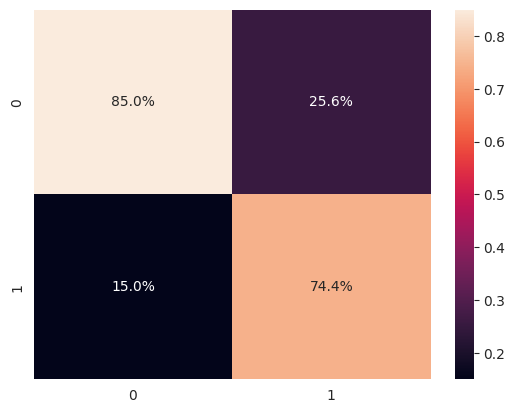

In [11]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, transformer_model, test, criterion=nn.BCEWithLogitsLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred)

In [42]:
resulting_pred, resulting_true = [], []
models = {}

for instrument in idx_to_instrument.values():
    model = LSTMModel(128).to(DEVICE)
    train, val, test = dataloaders[instrument]
    train_progress, val_progress = executor(
        DEVICE,
        model,
        train_dataloader=train,
        val_dataloader=val,
        epochs=100,
        learning_rate=0.0001,
        weight_decay=0.01,
        evaluate_per_iteration=20,
        early_stop_after=(15,  0.001)
    )
    test_loss, test_accuracy, (test_pred, test_true) = evaluate(
        DEVICE,
        model,
        test,
        criterion=nn.BCEWithLogitsLoss(),
        return_pred=True
    )

    models[instrument] = model

    resulting_pred.append(test_pred)
    resulting_true.append(test_true)

    # Строим classification_report для тренировочного и тестового датасета
    print('-' * 52)
    print(instrument)

    print('\tTEST')
    print(classification_report(test_true.cpu(), test_pred.cpu(), zero_division=0))


  7%|▋         | 7/100 [00:03<00:52,  1.77it/s]


KeyboardInterrupt: 

In [ ]:
print('INSTRUMENT MACRO ACCURACY:', calculate_accuracy(torch.concat(resulting_pred), torch.concat(resulting_true)))

In [ ]:
sns.catplot(
    pd.DataFrame(
        columns=idx_to_instrument.values(),
        data=[[calculate_accuracy(*x) for x in zip(resulting_pred, resulting_true)]]
    ),
    kind = 'bar'
)
plt.xticks(rotation=90)
;

In [ ]:
test_dataloaders = {
    key: value[2] for key, value in dataloaders.items()
}

true_matrix, pred_matrix = evaluate_multilabel(DEVICE, models, matrix_shape=(shapes[2], len(instrument_to_idx)), dataloaders=test_dataloaders, instrument_to_idx=instrument_to_idx)

print('TEST')
m1 = squeeze_answer_matrix(true_matrix)
m2 = squeeze_answer_matrix(pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

In [13]:
resulting_pred, resulting_true = [], []
models = {}

for instrument in idx_to_instrument.values():
    model = TransformerModel(input_dim=128,
                             num_layers=4,
                             output_dim=1,
                             num_heads=8,
                             dropout=0.1,
                             hidden_dim=128
                             ).to(DEVICE)
    train, val, test = dataloaders[instrument]
    train_progress, val_progress = executor(
        DEVICE,
        model,
        train_dataloader=train,
        val_dataloader=val,
        epochs=200,
        learning_rate=0.0001,
        weight_decay=0.01,
        evaluate_per_iteration=20,
        early_stop_after=(15,  0.001)
    )
    test_loss, test_accuracy, (test_pred, test_true) = evaluate(
        DEVICE,
        model,
        test,
        criterion=nn.BCEWithLogitsLoss(),
        return_pred=True
    )

    models[instrument] = model

    resulting_pred.append(test_pred)
    resulting_true.append(test_true)

    # Строим classification_report для тренировочного и тестового датасета
    print('-' * 52)
    print(instrument)

    print('\tTEST')
    print(classification_report(test_true.cpu(), test_pred.cpu(), zero_division=0))


 19%|█▉        | 38/200 [00:55<03:56,  1.46s/it]


Early stop!
----------------------------------------------------
accordion
	TEST
              precision    recall  f1-score   support

       False       0.84      0.94      0.89       225
        True       0.71      0.45      0.55        71

    accuracy                           0.82       296
   macro avg       0.78      0.70      0.72       296
weighted avg       0.81      0.82      0.81       296



 14%|█▍        | 29/200 [00:47<04:38,  1.63s/it]


Early stop!
----------------------------------------------------
banjo
	TEST
              precision    recall  f1-score   support

       False       0.84      0.88      0.86       187
        True       0.71      0.64      0.67        85

    accuracy                           0.81       272
   macro avg       0.78      0.76      0.77       272
weighted avg       0.80      0.81      0.80       272



 24%|██▍       | 49/200 [01:02<03:11,  1.27s/it]


Early stop!
----------------------------------------------------
bass
	TEST
              precision    recall  f1-score   support

       False       0.90      0.90      0.90       220
        True       0.64      0.65      0.64        60

    accuracy                           0.85       280
   macro avg       0.77      0.78      0.77       280
weighted avg       0.85      0.85      0.85       280



 21%|██        | 42/200 [01:00<03:45,  1.43s/it]


Early stop!
----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.76      0.81      0.78       148
        True       0.81      0.76      0.78       156

    accuracy                           0.78       304
   macro avg       0.78      0.78      0.78       304
weighted avg       0.78      0.78      0.78       304



 42%|████▏     | 83/200 [02:14<03:09,  1.62s/it]


Early stop!
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.80      0.94      0.87       306
        True       0.47      0.17      0.25        86

    accuracy                           0.78       392
   macro avg       0.64      0.56      0.56       392
weighted avg       0.73      0.78      0.73       392



 24%|██▎       | 47/200 [00:53<02:54,  1.14s/it]


Early stop!
----------------------------------------------------
cymbals
	TEST
              precision    recall  f1-score   support

       False       0.97      0.88      0.92        83
        True       0.94      0.99      0.97       173

    accuracy                           0.95       256
   macro avg       0.96      0.93      0.95       256
weighted avg       0.95      0.95      0.95       256



 18%|█▊        | 37/200 [00:47<03:29,  1.28s/it]


Early stop!
----------------------------------------------------
drums
	TEST
              precision    recall  f1-score   support

       False       0.93      0.87      0.90        97
        True       0.92      0.96      0.94       151

    accuracy                           0.92       248
   macro avg       0.93      0.91      0.92       248
weighted avg       0.92      0.92      0.92       248



 27%|██▋       | 54/200 [01:17<03:28,  1.43s/it]


Early stop!
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.77      0.88      0.82       228
        True       0.63      0.44      0.52       108

    accuracy                           0.74       336
   macro avg       0.70      0.66      0.67       336
weighted avg       0.72      0.74      0.72       336



 13%|█▎        | 26/200 [00:27<03:07,  1.08s/it]


Early stop!
----------------------------------------------------
guitar
	TEST
              precision    recall  f1-score   support

       False       0.92      0.96      0.94        98
        True       0.98      0.95      0.96       166

    accuracy                           0.95       264
   macro avg       0.95      0.96      0.95       264
weighted avg       0.96      0.95      0.95       264



 20%|██        | 41/200 [00:49<03:11,  1.21s/it]


Early stop!
----------------------------------------------------
mallet_percussion
	TEST
              precision    recall  f1-score   support

       False       0.80      0.81      0.81       171
        True       0.72      0.70      0.71       117

    accuracy                           0.77       288
   macro avg       0.76      0.76      0.76       288
weighted avg       0.77      0.77      0.77       288



 15%|█▌        | 30/200 [00:55<05:14,  1.85s/it]


Early stop!
----------------------------------------------------
mandolin
	TEST
              precision    recall  f1-score   support

       False       0.83      0.84      0.83       244
        True       0.65      0.65      0.65       116

    accuracy                           0.78       360
   macro avg       0.74      0.74      0.74       360
weighted avg       0.77      0.78      0.77       360



  9%|▉         | 18/200 [00:22<03:44,  1.24s/it]


Early stop!
----------------------------------------------------
organ
	TEST
              precision    recall  f1-score   support

       False       0.78      0.93      0.85       190
        True       0.70      0.39      0.50        82

    accuracy                           0.76       272
   macro avg       0.74      0.66      0.67       272
weighted avg       0.75      0.76      0.74       272



 46%|████▌     | 91/200 [01:41<02:01,  1.12s/it]


Early stop!
----------------------------------------------------
piano
	TEST
              precision    recall  f1-score   support

       False       0.97      0.89      0.93        70
        True       0.96      0.99      0.97       194

    accuracy                           0.96       264
   macro avg       0.96      0.94      0.95       264
weighted avg       0.96      0.96      0.96       264



 22%|██▏       | 43/200 [01:10<04:16,  1.64s/it]


Early stop!
----------------------------------------------------
saxophone
	TEST
              precision    recall  f1-score   support

       False       0.87      0.81      0.84       190
        True       0.80      0.86      0.83       170

    accuracy                           0.83       360
   macro avg       0.83      0.83      0.83       360
weighted avg       0.84      0.83      0.83       360



 14%|█▎        | 27/200 [00:31<03:23,  1.18s/it]


Early stop!
----------------------------------------------------
synthesizer
	TEST
              precision    recall  f1-score   support

       False       0.89      0.82      0.86        51
        True       0.94      0.97      0.96       157

    accuracy                           0.93       208
   macro avg       0.92      0.90      0.91       208
weighted avg       0.93      0.93      0.93       208



 18%|█▊        | 37/200 [01:22<06:02,  2.22s/it]


Early stop!
----------------------------------------------------
trombone
	TEST
              precision    recall  f1-score   support

       False       0.85      0.92      0.88       295
        True       0.68      0.51      0.58        97

    accuracy                           0.82       392
   macro avg       0.77      0.71      0.73       392
weighted avg       0.81      0.82      0.81       392



 37%|███▋      | 74/200 [02:55<04:58,  2.37s/it]


Early stop!
----------------------------------------------------
trumpet
	TEST
              precision    recall  f1-score   support

       False       0.80      0.91      0.85       288
        True       0.77      0.57      0.66       152

    accuracy                           0.79       440
   macro avg       0.79      0.74      0.75       440
weighted avg       0.79      0.79      0.78       440



 34%|███▎      | 67/200 [01:56<03:50,  1.74s/it]


Early stop!
----------------------------------------------------
ukulele
	TEST
              precision    recall  f1-score   support

       False       0.85      0.86      0.85       249
        True       0.67      0.65      0.66       111

    accuracy                           0.79       360
   macro avg       0.76      0.75      0.76       360
weighted avg       0.79      0.79      0.79       360



 18%|█▊        | 36/200 [00:49<03:46,  1.38s/it]


Early stop!
----------------------------------------------------
violin
	TEST
              precision    recall  f1-score   support

       False       0.69      0.74      0.71       120
        True       0.89      0.86      0.87       280

    accuracy                           0.82       400
   macro avg       0.79      0.80      0.79       400
weighted avg       0.83      0.82      0.82       400



 11%|█         | 22/200 [00:25<03:24,  1.15s/it]

Early stop!
----------------------------------------------------
voice
	TEST
              precision    recall  f1-score   support

       False       0.91      0.86      0.89        96
        True       0.89      0.93      0.91       112

    accuracy                           0.90       208
   macro avg       0.90      0.90      0.90       208
weighted avg       0.90      0.90      0.90       208



In [14]:
print('INSTRUMENT MACRO ACCURACY:', calculate_accuracy(torch.concat(resulting_pred), torch.concat(resulting_true)))

INSTRUMENT MACRO ACCURACY: 82.9520034790039


''

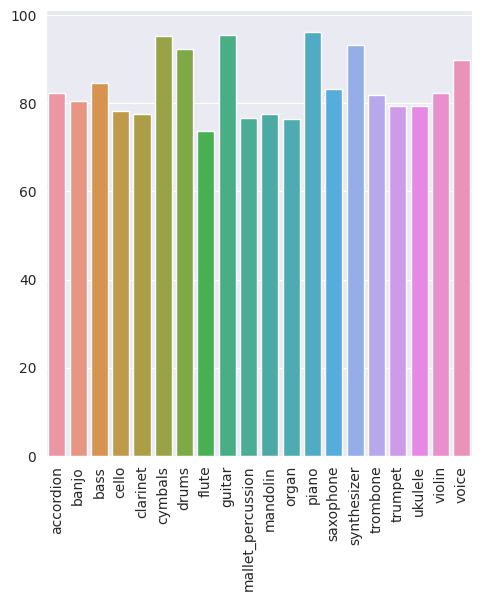

In [15]:
sns.catplot(
    pd.DataFrame(
        columns=idx_to_instrument.values(),
        data=[[calculate_accuracy(*x) for x in zip(resulting_pred, resulting_true)]]
    ),
    kind = 'bar'
)
plt.xticks(rotation=90)
;

In [16]:
test_dataloaders = {
    key: value[2] for key, value in dataloaders.items()
}

true_matrix, pred_matrix = evaluate_multilabel(DEVICE, models, matrix_shape=(shapes[2], len(instrument_to_idx)), dataloaders=test_dataloaders, instrument_to_idx=instrument_to_idx)

print('TEST')
m1 = squeeze_answer_matrix(true_matrix)
m2 = squeeze_answer_matrix(pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

TEST
Exact Match Ratio 0.709603408718453
Accuracy 0.7559925707418331
